## Import some useful setup code

In [1]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from eecs598 import reset_seed, Solver

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

use gpu to accelerate our computation

In [2]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# Load CIFAR-10 dataset

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

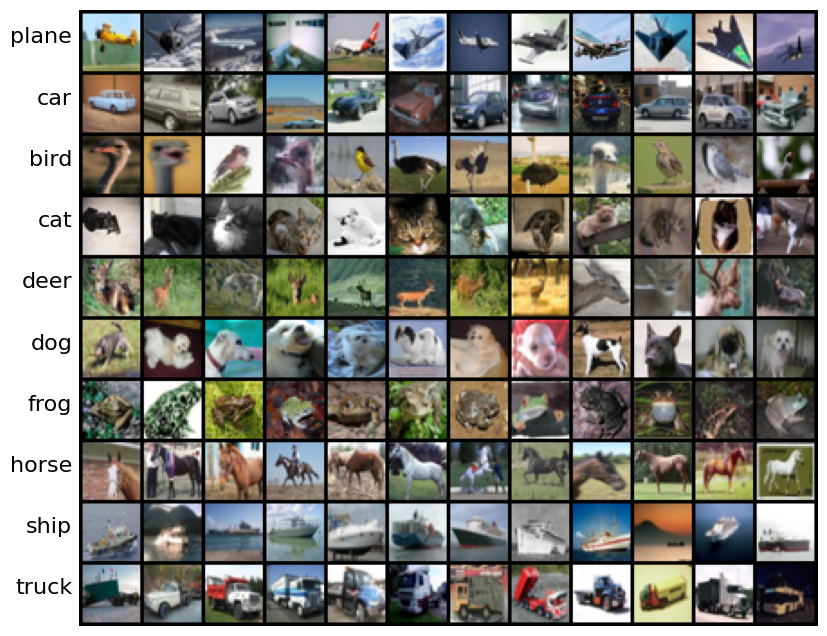

Train data shape:  torch.Size([40000, 3072])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3072])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3072])
Test labels shape:  torch.Size([10000])


In [3]:
import eecs598

eecs598.reset_seed(0)
data_dict = eecs598.data.preprocess_cifar10(cuda=True, dtype=torch.float64)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Linear layer : forward

In [4]:
from fully_connected_networks import Linear
# Test the Linear.forward function
num_inputs = 2
input_shape = torch.tensor((4, 5, 6))
output_dim = 3

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, dtype=torch.float64, device='cuda')
w = torch.linspace(-0.2, 0.3, steps=weight_size, dtype=torch.float64, device='cuda')
b = torch.linspace(-0.3, 0.1, steps=output_dim, dtype=torch.float64, device='cuda')
x = x.reshape(num_inputs, *input_shape)
w = w.reshape(torch.prod(input_shape), output_dim)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[1.49834984, 1.70660150, 1.91485316],
                            [3.25553226, 3.51413301, 3.77273372]]
                            ).double().cuda()

print('Testing Linear.forward function:')
print('difference: ', eecs598.grad.rel_error(out, correct_out))

Testing Linear.forward function:
difference:  3.6830429120909964e-08


# Linear layer : backword

In [5]:
from fully_connected_networks import Linear
# Test the Linear.backward function
reset_seed(0)
x = torch.randn(10, 2, 3, dtype=torch.float64, device='cuda')
w = torch.randn(6, 5, dtype=torch.float64, device='cuda')
b = torch.randn(5, dtype=torch.float64, device='cuda')
dout = torch.randn(10, 5, dtype=torch.float64, device='cuda')

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))

Testing Linear.backward function:
dx error:  5.170864758949246e-10
dw error:  3.293741405059995e-10
db error:  5.373171200544344e-10


# ReLU activation : forward

In [6]:
from fully_connected_networks import ReLU
reset_seed(0)
x = torch.linspace(-0.5, 0.5, steps=12, dtype=torch.float64, device='cuda')
x = x.reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            dtype=torch.float64,
                            device='cuda')

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', eecs598.grad.rel_error(out, correct_out))

Testing ReLU.forward function:
difference:  4.5454545613554664e-09


# ReLu activation : backward

In [7]:
from fully_connected_networks import ReLU
reset_seed(0)
x = torch.randn(10, 10, dtype=torch.float64, device='cuda')
dout = torch.randn(*x.shape, dtype=torch.float64, device='cuda')
dx_num = eecs598.grad.compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)
_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)
# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))

Testing ReLU.backward function:
dx error:  2.6317796097761553e-10


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.


In [8]:
from fully_connected_networks import Linear_ReLU
reset_seed(0)
x = torch.randn(2, 3, 4, dtype=torch.float64, device='cuda')
w = torch.randn(12, 10, dtype=torch.float64, device='cuda')
b = torch.randn(10, dtype=torch.float64, device='cuda')
dout = torch.randn(2, 10, dtype=torch.float64, device='cuda')

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = eecs598.grad.compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = eecs598.grad.compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))
print('dw error: ', eecs598.grad.rel_error(dw_num, dw))
print('db error: ', eecs598.grad.rel_error(db_num, db))

Testing Linear_ReLU.forward and Linear_ReLU.backward:
dx error:  1.4564739946431168e-09
dw error:  6.424556508465271e-10
db error:  8.915028842081707e-10


# Loss layers : Softmax and SVM

In [9]:
from a3_helper import svm_loss, softmax_loss

reset_seed(0)
num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, dtype=torch.float64, device='cuda')
y = torch.randint(num_classes, size=(num_inputs,), dtype=torch.int64, device='cuda')

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss.item())
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))

dx_num = eecs598.grad.compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', eecs598.grad.rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.000430792478463
dx error:  7.97306008441663e-09

Testing softmax_loss:
loss:  2.3026286102347924
dx error:  1.0417990899757076e-07


# Two-layer network

In [10]:
from fully_connected_networks import TwoLayerNet
from a3_helper import svm_loss, softmax_loss

reset_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

std = 1e-3
model = TwoLayerNet(
          input_dim=D,
          hidden_dim=H,
          num_classes=C,
          weight_scale=std,
          dtype=torch.float64,
          device='cuda'
        )

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D * H, dtype=torch.float64, device='cuda').reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, dtype=torch.float64, device='cuda')
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H * C, dtype=torch.float64, device='cuda').reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, dtype=torch.float64, device='cuda')
X = torch.linspace(-5.5, 4.5, steps=N * D, dtype=torch.float64, device='cuda').reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    dtype=torch.float64, device='cuda')
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 2.28e-07
W2 relative error: 1.45e-09
b1 relative error: 9.91e-07
b2 relative error: 4.99e-09
Running numeric gradient check with reg =  0.7
W1 relative error: 3.16e-08
W2 relative error: 8.40e-09
b1 relative error: 6.27e-07
b2 relative error: 2.72e-08


# Solver

In [11]:
print(help(Solver))

Help on class Solver in module eecs598.solver:

class Solver(builtins.object)
 |  Solver(model, data, **kwargs)
 |  
 |  A Solver encapsulates all the logic necessary for training classification
 |  models. The Solver performs stochastic gradient descent using different
 |  update rules.
 |  The solver accepts both training and validation data and labels so it can
 |  periodically check classification accuracy on both training and validation
 |  data to watch out for overfitting.
 |  To train a model, you will first construct a Solver instance, passing the
 |  model, dataset, and various options (learning rate, batch size, etc) to the
 |  constructor. You will then call the train() method to run the optimization
 |  procedure and train the model.
 |  After the train() method returns, model.params will contain the parameters
 |  that performed best on the validation set over the course of training.
 |  In addition, the instance variable solver.loss_history will contain a list
 |  of all

In [12]:
from fully_connected_networks import create_solver_instance

reset_seed(0)

# Create a solver instance that achieves 50% performance on the validation set
solver = create_solver_instance(data_dict=data_dict, dtype=torch.float64, device='cuda')
solver.train()

(Time 0.03 sec; Iteration 1 / 800) loss: 2.302587
(Epoch 0 / 10) train acc: 0.115000; val_acc: 0.101400
(Epoch 1 / 10) train acc: 0.358000; val_acc: 0.342200
(Epoch 2 / 10) train acc: 0.365000; val_acc: 0.357400
(Epoch 3 / 10) train acc: 0.410000; val_acc: 0.403300
(Epoch 4 / 10) train acc: 0.520000; val_acc: 0.464200
(Epoch 5 / 10) train acc: 0.486000; val_acc: 0.448800
(Epoch 6 / 10) train acc: 0.516000; val_acc: 0.471200
(Time 8.14 sec; Iteration 501 / 800) loss: 1.250751
(Epoch 7 / 10) train acc: 0.527000; val_acc: 0.486400
(Epoch 8 / 10) train acc: 0.575000; val_acc: 0.491500
(Epoch 9 / 10) train acc: 0.597000; val_acc: 0.507800
(Epoch 10 / 10) train acc: 0.584000; val_acc: 0.503800


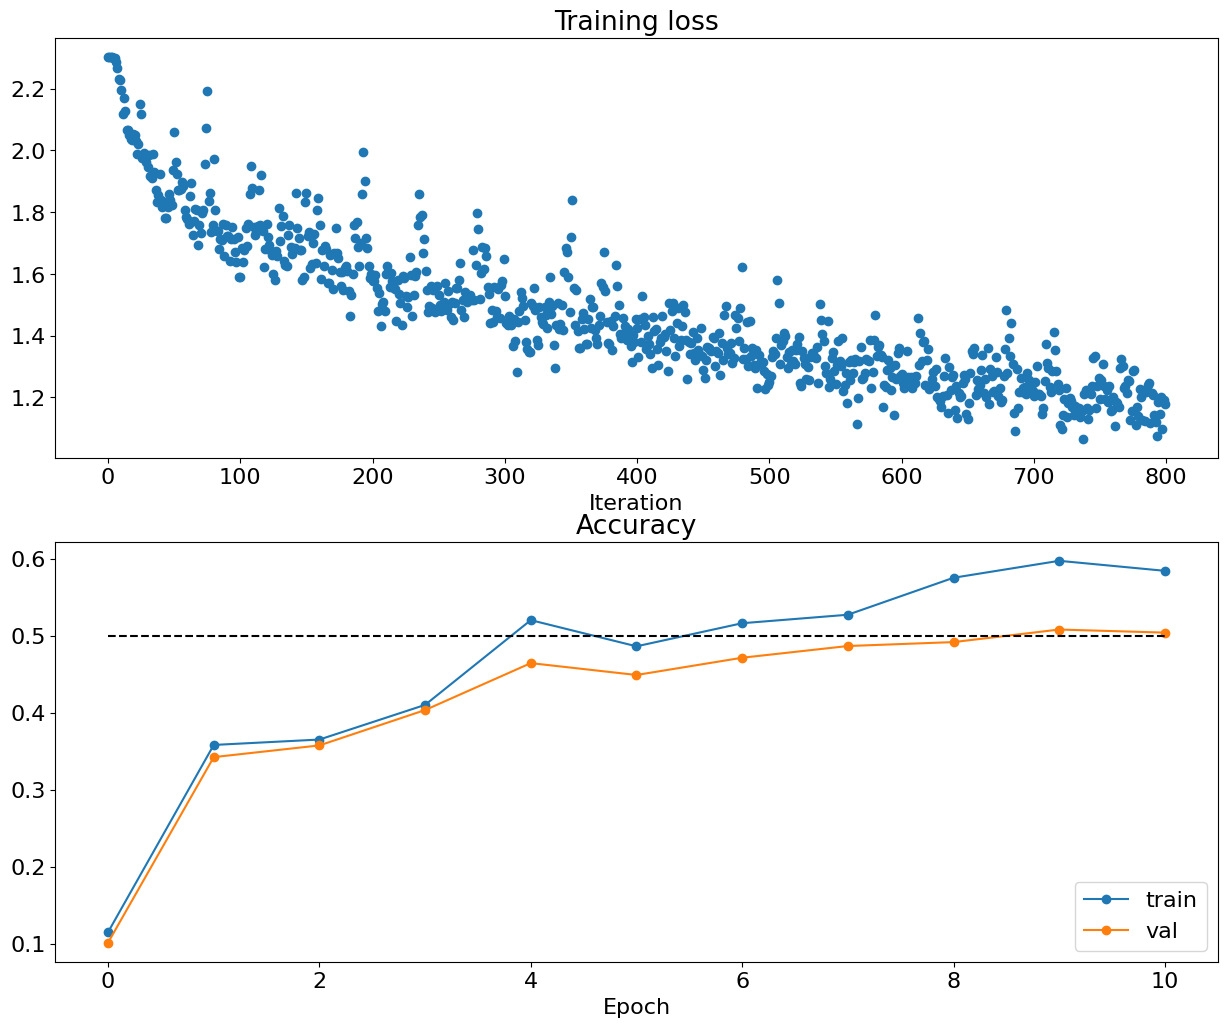

In [13]:
# Run this cell to visualize training loss and train / val accuracy
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
## Initial loss and gradient check

In [14]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet(
        [H1, H2], 
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2, 
        dtype=torch.float64, 
        device='cuda'
  )

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.307533872340282
W1 relative error: 4.71e-08
W2 relative error: 9.16e-08
W3 relative error: 4.72e-08
b1 relative error: 9.39e-08
b2 relative error: 2.42e-08
b3 relative error: 2.39e-09
Running check with reg =  3.14
Initial loss:  7.063988454673523
W1 relative error: 7.86e-09
W2 relative error: 9.95e-09
W3 relative error: 1.05e-08
b1 relative error: 6.20e-07
b2 relative error: 1.00e-07
b3 relative error: 6.20e-09


(Time 0.00 sec; Iteration 1 / 40) loss: 2.312459
(Epoch 0 / 20) train acc: 0.320000; val_acc: 0.108300
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.114800
(Epoch 2 / 20) train acc: 0.240000; val_acc: 0.097100
(Epoch 3 / 20) train acc: 0.300000; val_acc: 0.145000
(Epoch 4 / 20) train acc: 0.440000; val_acc: 0.140200
(Epoch 5 / 20) train acc: 0.540000; val_acc: 0.171000
(Time 0.37 sec; Iteration 11 / 40) loss: 1.481615
(Epoch 6 / 20) train acc: 0.380000; val_acc: 0.160700
(Epoch 7 / 20) train acc: 0.440000; val_acc: 0.128800
(Epoch 8 / 20) train acc: 0.720000; val_acc: 0.170300
(Epoch 9 / 20) train acc: 0.740000; val_acc: 0.191900
(Epoch 10 / 20) train acc: 0.860000; val_acc: 0.187400
(Time 0.56 sec; Iteration 21 / 40) loss: 0.581121
(Epoch 11 / 20) train acc: 0.840000; val_acc: 0.137600
(Epoch 12 / 20) train acc: 0.700000; val_acc: 0.147300
(Epoch 13 / 20) train acc: 0.840000; val_acc: 0.196500
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.195600
(Epoch 15 / 20) train acc: 1.000000;

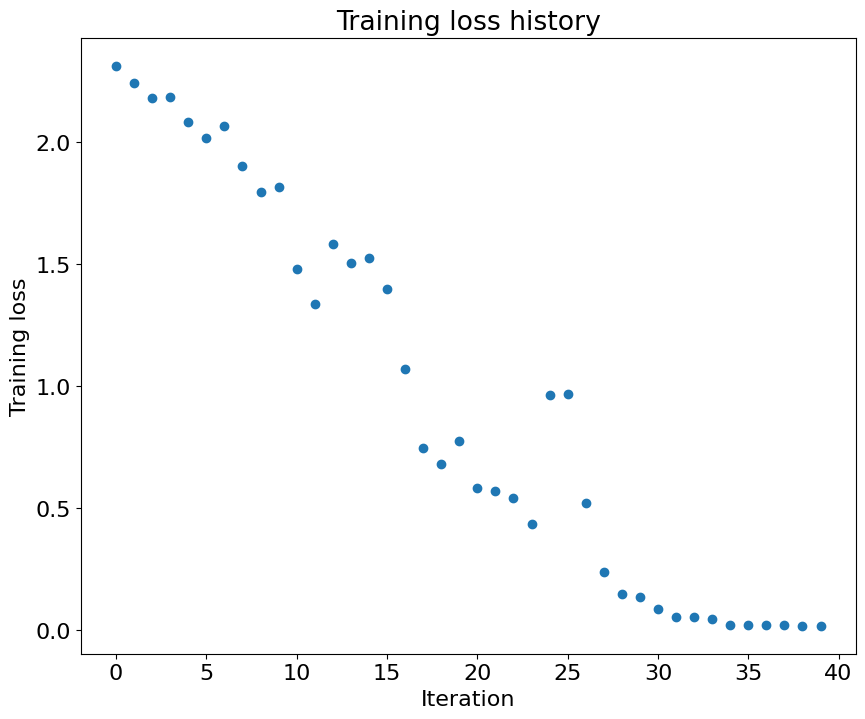

In [15]:
from fully_connected_networks import FullyConnectedNet, get_three_layer_network_params

# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_three_layer_network_params()

model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

(Time 0.01 sec; Iteration 1 / 40) loss: 18.173244
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.103400
(Epoch 1 / 20) train acc: 0.240000; val_acc: 0.119400
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.128800
(Epoch 3 / 20) train acc: 0.700000; val_acc: 0.126600
(Epoch 4 / 20) train acc: 0.900000; val_acc: 0.125400
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.123800
(Time 0.51 sec; Iteration 11 / 40) loss: 0.451857
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.124300
(Epoch 7 / 20) train acc: 1.000000; val_acc: 0.126600
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.128300
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.129800
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.130400
(Time 0.83 sec; Iteration 21 / 40) loss: 0.062391
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.130600
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.130200
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.130700
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.132000
(Epoch 15 / 20) train acc: 1.000000

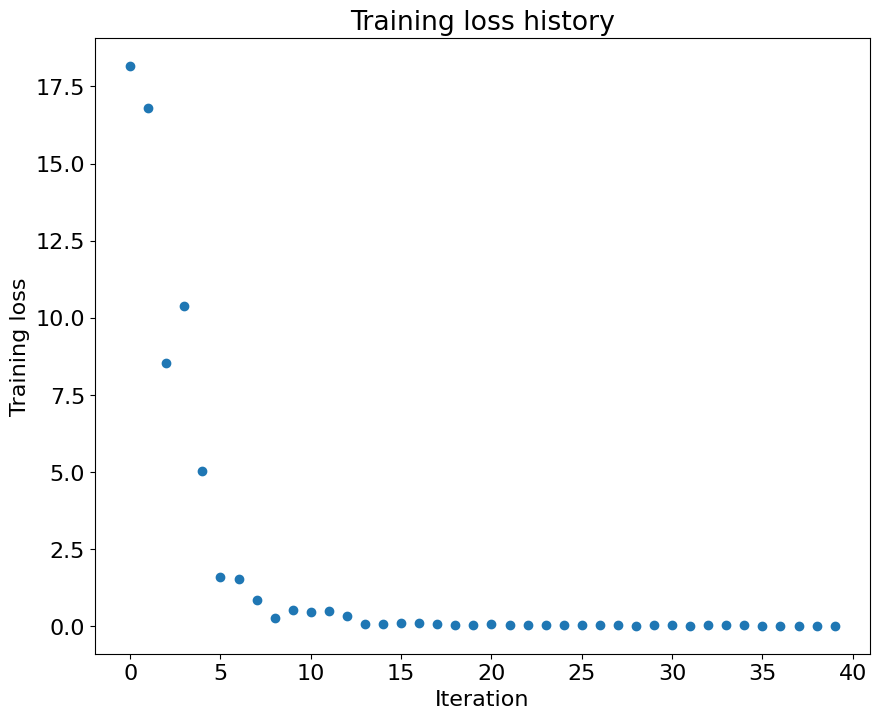

In [16]:
from fully_connected_networks import FullyConnectedNet, get_five_layer_network_params

# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
reset_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}


# Update parameters in get_three_layer_network_params
weight_scale, learning_rate = get_five_layer_network_params()

# Run models and solver with parameters
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=torch.float32, device='cuda')
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
# Turn off keep_best_params to allow final weights to be saved, instead of best weights on validation set.
solver.train(return_best_params=False)

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# SGD and Momentum

In [17]:
from fully_connected_networks import sgd_momentum

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]],
   dtype=torch.float64, device='cuda')
expected_velocity = torch.tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]],
   dtype=torch.float64, device='cuda')

# Should see relative errors around e-8 or less
print('next_w error: ', eecs598.grad.rel_error(next_w, expected_next_w))
print('velocity error: ', eecs598.grad.rel_error(expected_velocity, config['velocity']))

next_w error:  1.6802078709310813e-09
velocity error:  2.9254212825785614e-09


running with  sgd
(Time 0.00 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.100700
(Epoch 1 / 5) train acc: 0.112000; val_acc: 0.102800
(Epoch 2 / 5) train acc: 0.106000; val_acc: 0.096300
(Epoch 3 / 5) train acc: 0.114000; val_acc: 0.100800
(Epoch 4 / 5) train acc: 0.114000; val_acc: 0.099700
(Epoch 5 / 5) train acc: 0.114000; val_acc: 0.101700

running with  sgd_momentum
(Time 0.00 sec; Iteration 1 / 200) loss: 2.302985
(Epoch 0 / 5) train acc: 0.096000; val_acc: 0.088300
(Epoch 1 / 5) train acc: 0.114000; val_acc: 0.099700
(Epoch 2 / 5) train acc: 0.173000; val_acc: 0.164200
(Epoch 3 / 5) train acc: 0.180000; val_acc: 0.159100
(Epoch 4 / 5) train acc: 0.238000; val_acc: 0.219500
(Epoch 5 / 5) train acc: 0.293000; val_acc: 0.257000



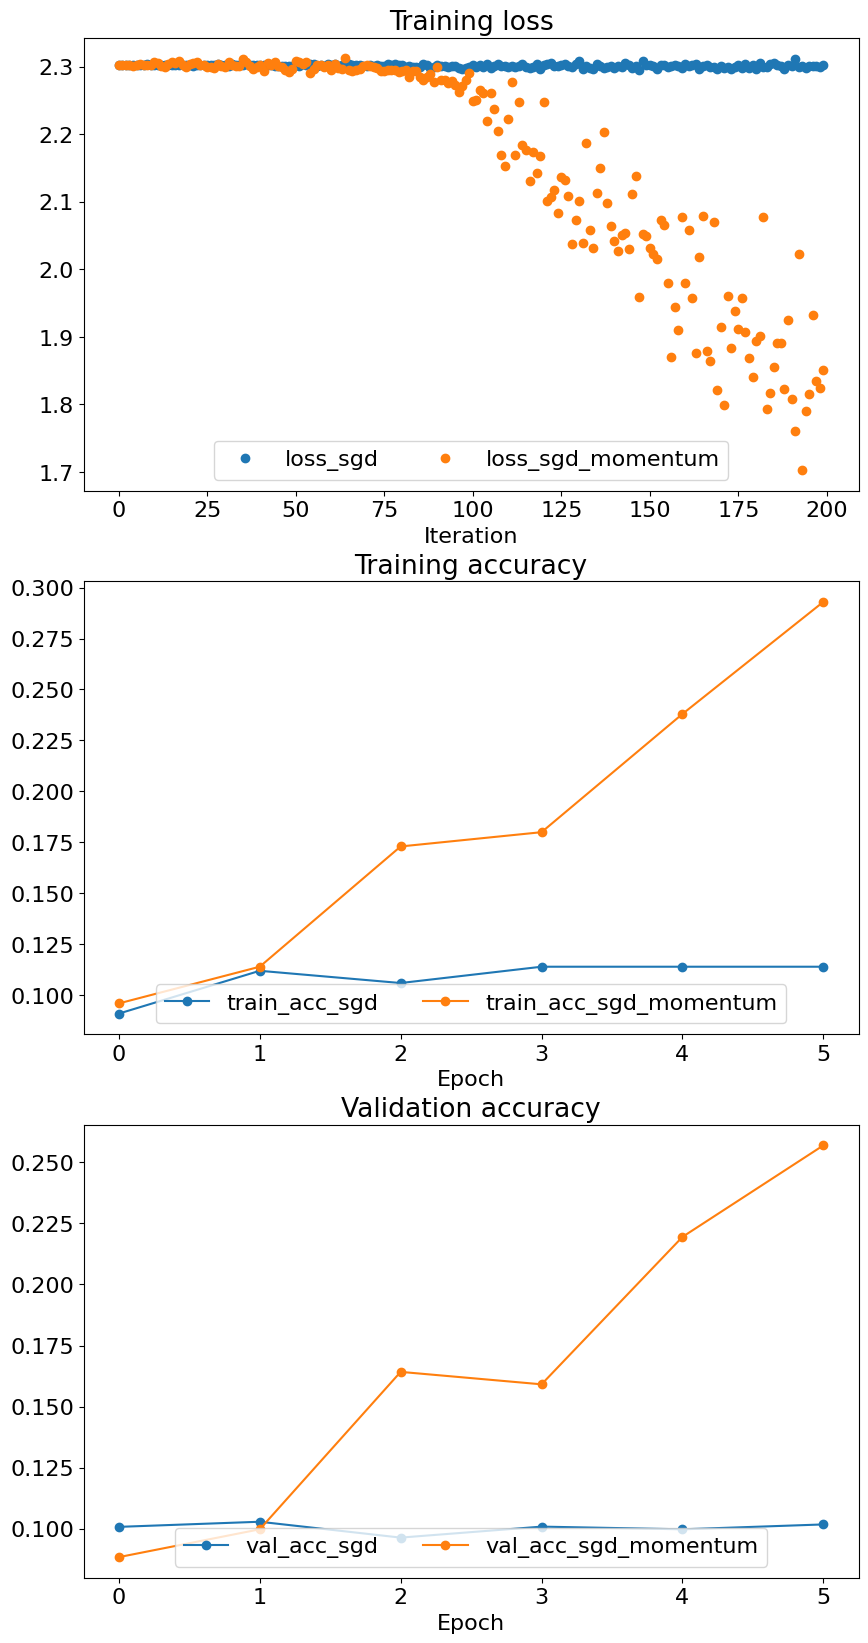

In [18]:
from fully_connected_networks import FullyConnectedNet, sgd, sgd_momentum

reset_seed(0)

num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            dtype=torch.float32, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

# RMSProp

In [19]:
from fully_connected_networks import rmsprop

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]],
   dtype=torch.float64, device='cuda')
expected_cache = torch.tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]],
   dtype=torch.float64, device='cuda')

print('next_w error: ', eecs598.grad.rel_error(expected_next_w, next_w))
print('cache error: ', eecs598.grad.rel_error(expected_cache, config['cache']))

next_w error:  4.064797880829826e-09
cache error:  1.8620321382570356e-09


# Adam

In [20]:
# Test Adam implementation
from fully_connected_networks import adam

reset_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D, dtype=torch.float64, device='cuda').reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]],
   dtype=torch.float64, device='cuda')
expected_v = torch.tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]],
   dtype=torch.float64, device='cuda')
expected_m = torch.tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]],
   dtype=torch.float64, device='cuda')

# You should see relative errors around e-7 or less
print('next_w error: ', eecs598.grad.rel_error(expected_next_w, next_w))
print('v error: ', eecs598.grad.rel_error(expected_v, config['v']))
print('m error: ', eecs598.grad.rel_error(expected_m, config['m']))

next_w error:  3.756728297598868e-09
v error:  3.4048987160545265e-09
m error:  2.786377729853651e-09


running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302626
(Epoch 0 / 5) train acc: 0.160000; val_acc: 0.147100
(Epoch 1 / 5) train acc: 0.251000; val_acc: 0.241700
(Epoch 2 / 5) train acc: 0.307000; val_acc: 0.286400
(Epoch 3 / 5) train acc: 0.360000; val_acc: 0.322200
(Epoch 4 / 5) train acc: 0.425000; val_acc: 0.342100
(Epoch 5 / 5) train acc: 0.465000; val_acc: 0.356300

running with  sgd_momentum
(Time 0.01 sec; Iteration 1 / 200) loss: 2.302985
(Epoch 0 / 5) train acc: 0.110000; val_acc: 0.109200
(Epoch 1 / 5) train acc: 0.253000; val_acc: 0.232900
(Epoch 2 / 5) train acc: 0.277000; val_acc: 0.263600
(Epoch 3 / 5) train acc: 0.310000; val_acc: 0.264600
(Epoch 4 / 5) train acc: 0.322000; val_acc: 0.284000
(Epoch 5 / 5) train acc: 0.336000; val_acc: 0.292700



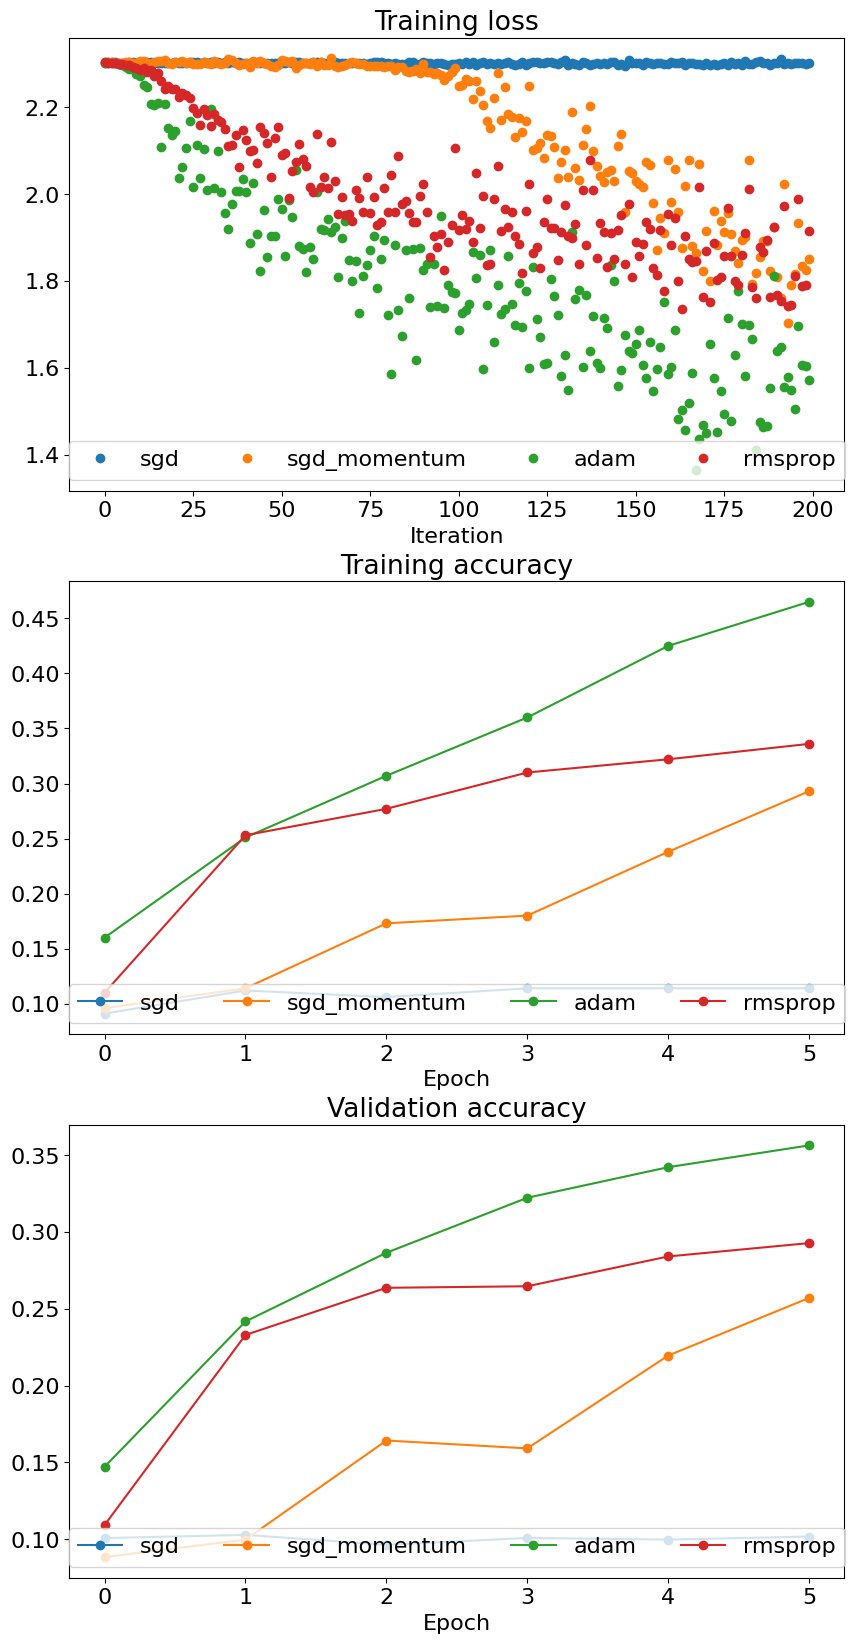

In [21]:
# Test Adam implementation
from fully_connected_networks import adam, rmsprop, FullyConnectedNet

for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='lower center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='lower center', ncol=4)

plt.gcf().set_size_inches(10, 20)
plt.show()

# Dropout : forward

In [22]:
from fully_connected_networks import Dropout

reset_seed(0)
x = torch.randn(500, 500, dtype=torch.float64, device='cuda') + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print(out.dtype)

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

torch.float64
Running tests with p =  0.25
Mean of input:  9.999363323877896
Mean of train-time output:  9.990662915718602
Mean of test-time output:  9.999363323877896
Fraction of train-time output set to zero:  0.2505599856376648
Fraction of test-time output set to zero:  0.0

torch.float64
Running tests with p =  0.4
Mean of input:  9.999363323877896
Mean of train-time output:  9.974636010279736
Mean of test-time output:  9.999363323877896
Fraction of train-time output set to zero:  0.40133199095726013
Fraction of test-time output set to zero:  0.0

torch.float64
Running tests with p =  0.7
Mean of input:  9.999363323877896
Mean of train-time output:  10.012350710230168
Mean of test-time output:  9.999363323877896
Fraction of train-time output set to zero:  0.6997119784355164
Fraction of test-time output set to zero:  0.0



# Dropout : backword

In [23]:
from fully_connected_networks import Dropout

reset_seed(0)
x = torch.randn(10, 10, dtype=torch.float64, device='cuda') + 10
dout = torch.randn_like(x)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 0}
out, cache = Dropout.forward(x, dropout_param)
dx = Dropout.backward(dout, cache)
dx_num = eecs598.grad.compute_numeric_gradient(lambda xx: Dropout.forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', eecs598.grad.rel_error(dx, dx_num))

dx relative error:  3.914942325636866e-09


# Fully-connected nn with dropout

In [24]:
from fully_connected_networks import FullyConnectedNet

reset_seed(0)

N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, dtype=torch.float64, device='cuda')
y = torch.randint(C, size=(N,), dtype=torch.int64, device='cuda')

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dropout=dropout,
                            seed=0, dtype=torch.float64, device='cuda')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())
  
  # Relative errors should be around e-5 or less.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eecs598.grad.compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, eecs598.grad.rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  0
Initial loss:  2.307533872340282
W1 relative error: 4.71e-08
W2 relative error: 9.16e-08
W3 relative error: 4.72e-08
b1 relative error: 9.39e-08
b2 relative error: 2.42e-08
b3 relative error: 2.39e-09

Running check with dropout =  0.25
Initial loss:  2.3024712491074784
W1 relative error: 6.99e-08
W2 relative error: 7.49e-08
W3 relative error: 3.67e-08
b1 relative error: 1.46e-07
b2 relative error: 1.96e-08
b3 relative error: 4.32e-09

Running check with dropout =  0.5
Initial loss:  2.3084634160711257
W1 relative error: 4.78e-08
W2 relative error: 3.19e-08
W3 relative error: 3.18e-08
b1 relative error: 2.95e-08
b2 relative error: 1.80e-08
b3 relative error: 3.25e-09



# Regularization experiment

In [25]:
from fully_connected_networks import FullyConnectedNet

# Train two identical nets, one with dropout and one without
reset_seed(0)
num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, dtype=torch.float32, device='cuda')
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device='cuda')
  solver.train()
  solvers[(dropout, width)] = solver
  print()

Training a model with dropout=0.00 and width=256
(Time 0.02 sec; Iteration 1 / 3900) loss: 2.300956
(Epoch 0 / 100) train acc: 0.259000; val_acc: 0.245700
(Epoch 10 / 100) train acc: 0.664000; val_acc: 0.468900
(Epoch 20 / 100) train acc: 0.872000; val_acc: 0.478600
(Epoch 30 / 100) train acc: 0.929000; val_acc: 0.470400
(Epoch 40 / 100) train acc: 0.953000; val_acc: 0.474500
(Epoch 50 / 100) train acc: 0.973000; val_acc: 0.472900
(Epoch 60 / 100) train acc: 0.954000; val_acc: 0.464600
(Epoch 70 / 100) train acc: 0.995000; val_acc: 0.470900
(Epoch 80 / 100) train acc: 0.953000; val_acc: 0.472000
(Epoch 90 / 100) train acc: 0.997000; val_acc: 0.464700
(Epoch 100 / 100) train acc: 0.954000; val_acc: 0.458500

Training a model with dropout=0.00 and width=512
(Time 0.00 sec; Iteration 1 / 3900) loss: 2.305852
(Epoch 0 / 100) train acc: 0.179000; val_acc: 0.183200
(Epoch 10 / 100) train acc: 0.726000; val_acc: 0.477000
(Epoch 20 / 100) train acc: 0.851000; val_acc: 0.482000
(Epoch 30 / 100)

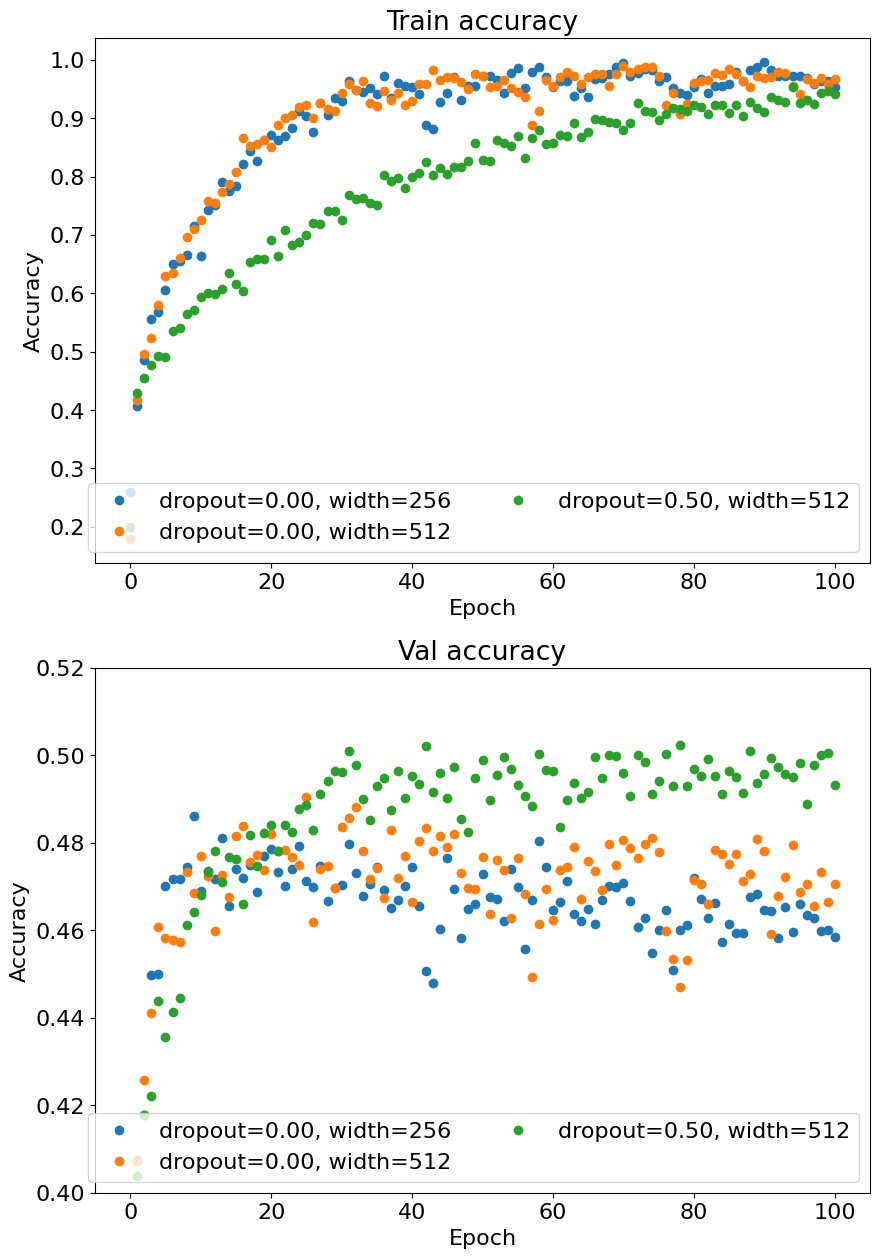

In [26]:
plt.subplot(2, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(2, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 15)
plt.show()